In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://drive.google.com/open?id=1SCxL_JlKANLPwIFsGJF1QCx9Mc9FanoQ' width=500px> 

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
!ls '/content/gdrive/My Drive/DataScience/p2_image_classifier/flowers'

test  train  valid


In [0]:
 #Imports
import matplotlib.pyplot as plt
from PIL import Image
import torch
import json
import os
import time
import copy

import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch import nn as nn
from torch import optim as optim
from torch import cuda as cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchsummary import summary as summary
from torchvision import datasets, models, transforms
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [0]:
# Define some utility classes
batch_size = 10
data_dir = '/content/gdrive/My Drive/DataScience/p2_image_classifier/flowers'
train_dir = data_dir + '/train/'
validation_dir = data_dir + '/valid/'
test_dir = data_dir + '/test/'

channels_mean_sequence = [0.485, 0.456, 0.406]
channels_standard_deviation_sequence = [0.229, 0.224, 0.225]
dimensions = [224, 224]
extra_dimensions = [256, 256]


images_dataset_names = ['training_images','test_images', 'validation_images']
image_directories = {images_dataset_names[0]:train_dir, 
                     images_dataset_names[1]:test_dir, images_dataset_names[2]:validation_dir}

class Analyzer:
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.training_accuracy = []
        self.validation_accuracy = []
        
    def addlosses(self, losses, work_flow_phase, epoch):
        if work_flow_phase == 'training_images':
           tripple = (work_flow_phase, epoch, losses)
           self.training_losses.append(tripple)
        elif work_flow_phase == 'validation_images':
           tripple = (work_flow_phase, epoch, losses)
           self.validation_losses.append(tripple)
            
    def addaccuracy(self, accuracy, work_flow_phase, epoch):
        if work_flow_phase == 'training_images':
           tripple = (work_flow_phase, epoch, accuracy)
           self.training_accuracy.append(tripple)
        elif work_flow_phase == 'validation_images':
           tripple = (work_flow_phase, epoch, accuracy)
           self.validation_accuracy.append(tripple)
            
    def plotlosses(self):
        training_losses = []
        validation_losses = []
        epochs = []
        first = self.training_losses[0]
        training_phase = first[0]
        for tripple in self.training_losses:
            epochs.append(tripple[1])
            training_losses.append(tripple[2])
        
        first = self.validation_losses[0]
        validation_phase = first[0]
        for tripple in self.validation_losses:
            validation_losses.append(tripple[2])
        
        plt.plot(epochs, training_losses , 'r--', label=training_phase)
        plt.plot(epochs, validation_losses, 'g^', label=validation_phase)
        plt.show()
    
    def plotaccuracy(self):
        training_accuracies = []
        validation_accuracies = []
        epochs = []
        first = self.training_accuracy[0]
        training_phase = first[0]
        for tripple in self.training_accuracy:
            epochs.append(tripple[1])
            training_accuracies.append(tripple[2])
        
        first = self.validation_accuracy[0]
        validation_phase = first[0]
        for tripple in self.validation_accuracy:
            validation_accuracies.append(tripple[2])
        
        plt.plot(epochs, training_accuracies, label=training_phase)
        plt.plot(epochs, validation_accuracies, 'bs', label=validation_phase)
        plt.show()

class ImageConverter:
    def __init__(self, tensor):
        self.tensor = tensor
    def convert(self, tensor):
         converted = self.tensor.cpu().clone().detach().numpy()
         converted = image.transpose(1, 2, 0)
         converted = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
         converted = image.clip(0, 1)
         return image
    
class Check_point_manager:
    def __init__(self, modelName, best_model_wts, linear_classifier,optimizer, model):
        self.saved_state = {'arch_name':modelName,
                            'best_model_wts':best_model_wts,
                            'linear_classifier':linear_classifier,
                            'optimizer_state':optimizer.,
                            'class_to_idx': model.class_to_idx,
                            'idx_to_class': model.idx_to_class
                           }
        
    def save_state(self, path):
        torch.save(self.saved_state, path)
    
    def load_state(self, path):
        self.elf.saved_state = torch.load(path)
    
class NeuralNetworkModelBuilder:
    def __init__(self, modelName):
        self.n_outputs = 102
        self.modelName = modelName
        
        if modelName != None and modelName == "AlexNet":
            self.model = models.alexnet(pretrained=True)
        elif modelName != None and modelName == "VGG16":
            self.model = models.vgg16(pretrained=True)
        elif modelName != None and modelName == "VGG19":
            self.model = models.vgg19(pretrained=True)
        elif modelName != None and modelName == "ResNet18":
            self.model = models.resnet18(pretrained=True)
        else:
            self.model = models.vgg19(pretrained=True)
            
        for param in self.model.parameters():
            param.requires_grad_(False)
    
    def getPretrainedCNNModel(self):
        return self.model
    
    def buildAndAddFullyConnectedLayer(self, modelName):
        if modelName != None and modelName == "VGG16":
            number_of_inputs = self.model.classifier[0].in_features
            fclayer1 = nn.Linear(number_of_inputs, 4096)
            relu = nn.ReLU()
            fclayer2 = nn.Linear(4096, self.n_outputs)
            output = nn.LogSoftmax(dim=1)
            dropout = nn.Dropout(0.3)
            classifier = nn.Sequential(
                                       fclayer1 ,
                                       relu,
                                       #dropout,
                                       fclayer2,
                                       output
                                       )
            #self.model.classifier[6] = classifier
            self.model.classifier = classifier
        elif modelName != None and modelName == "VGG19":
            number_of_inputs = self.model.classifier[0].in_features
            fclayer1 = nn.Linear(number_of_inputs, 4096)
            relu = nn.ReLU()
            fclayer2 = nn.Linear(4096, self.n_outputs)
            output = nn.LogSoftmax(dim=1)
            dropout = nn.Dropout(0.3)
            classifier = nn.Sequential(
                                       fclayer1 ,
                                       relu,
                                       #dropout,
                                       fclayer2,
                                       output
                                       )
            #self.model.classifier[6] = classifier
            self.model.classifier = classifier


In [0]:
class DataSets:
    def __init__(self, data_transforms):
        self.datasets = {idx: datasets.ImageFolder(image_directories[idx],   
                transform=data_transforms[idx]) 
                for idx in images_dataset_names}
    
    def get_data_sets(self):
        return self.datasets
    
    def get_training_dataset(self):
        key = images_dataset_names[0]
        return self.datasets[key]
    
    def get_validation_dataset(self):
        key = images_dataset_names[1]
        return self.datasets[key]
    
    def get_test_dataset(self):
        key = images_dataset_names[2]
        return self.datasets[key]

class Transforms:
    def __init__(self):
        transforms.RandomRotation(degrees=15),
        self.data_transforms = {
                                images_dataset_names[0]: transforms.Compose([
                                                     transforms.RandomRotation(25),
                                                     transforms.RandomResizedCrop(224),
                                                     #transforms.Resize(extra_dimensions), 
                                                     #transforms.CenterCrop(dimensions), 
                                                     transforms.RandomHorizontalFlip(),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(channels_mean_sequence, 
                                                                          channels_standard_deviation_sequence)
                                ]),
    
                                images_dataset_names[1]: transforms.Compose([
                                                     transforms.Resize(extra_dimensions), 
                                                     transforms.CenterCrop(dimensions), 
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(channels_mean_sequence, 
                                                                          channels_standard_deviation_sequence)
                                ]),
    
                                images_dataset_names[2]: transforms.Compose([
                                                     transforms.Resize(extra_dimensions),
                                                     transforms.CenterCrop(dimensions), 
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(channels_mean_sequence, 
                                                                          channels_standard_deviation_sequence)
                                ])
                               }
    def get_transforms(self):
        return self.data_transforms
    
    def get_transforms_for_training_data(self):
        key = images_dataset_names[0]
        return self.data_transforms[key]
    
    
    def get_transforms_for_validation_data(self):
        key = images_dataset_names[1]
        return self.data_transforms[key]
    
    
    def get_transforms_for_test_data(self):
        key = images_dataset_names[2]
        return self.data_transforms[key]


In [0]:
# Define variables and transforms for the training, validation, and testing sets
transformsLoc = Transforms()
data_transforms = transformsLoc.get_transforms()

image_datasets = DataSets(data_transforms).get_data_sets()

#training_dataset = datasets.ImageFolder(train_dir, transform=transformsLoc.get_transforms_for_training_data())
#validation_dataset = datasets.ImageFolder(validation_dir, transform=transformsLoc.get_transforms_for_validation_data())

#training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
#validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)
#print(len(training_dataset))
#print(len(validation_dataset))

#image_datasets = {idx: datasets.ImageFolder(image_directories[idx],   
#                 transform=data_transforms[idx]) 
#                 for idx in images_dataset_names}
#print(type(image_datasets))
#print(image_datasets)

#test_data_transforms = transformsLoc.get_transforms_for_test_data()
#print(test_data_transforms)

# Using the image datasets and the transforms, define the dataloaders

dataloaders = {ix: torch.utils.data.DataLoader(image_datasets[ix], 
               batch_size, shuffle=True) 
               for ix in images_dataset_names}

#print(dataloaders)

dataset_sizes = {x: len(image_datasets[x]) 
                 for x in images_dataset_names}

#print(dataset_sizes['training_images'])
class_names = image_datasets['training_images'].classes

In [0]:
with open('/content/gdrive/My Drive/DataScience/p2_image_classifier/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

#keys = cat_to_name.keys()
#print(sorted(keys)) #Just Checking
#print(len(cat_to_name))

In [0]:
class ModelTrainer:
    def __init__(self, model):
        self.batch_size = batch_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(self.device)
        self.model = model
        #self.dataloaders = dataloaders
        #self.val_dataloader = val_dataloader
        #self.train_dataloader = train_dataloader
        
        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr = 0.0001)
        self.epochs = 20
        self.phases = ['training_images','validation_images']
        self.epoch_loss = 0.0
        self.epoch_corrects = 0
        self.best_acc = 0.0
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=4, gamma=0.1)
        self.current_loss = 0.0
        self.current_currects = 0
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.analyzer = Analyzer()
        
        #print(dataloaders.keys())
        #print(dataloaders['test_images'])
        #itr = iter(self.dataloaders['test_images'])
        #x, y = itr.next()
        #print(x.to(self.device))
    def trainModel(self):
        since = time.time()
        #dataloader = self.train_dataloader 
        #best_model_wts = copy.deepcopy(self.model.state_dict())
        #best_acc = 0.0
        for epoch in range(self.epochs):
            self.epoch_loss = 0.0
            self.epoch_corrects = 0
            print('Epoch {}/{}'.format(epoch, self.epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            self.train_in_one_epoch(epoch)              
                
            #print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
              time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(self.best_acc))

        # load best model weights
        self.model.load_state_dict(self.best_model_wts)
        
        self.analyzer.plotlosses()
        self.analyzer.plotaccuracy()
        return
    
    def train_in_one_epoch(self, epoch):
      
        for phase in self.phases:
            self.current_loss = 0.0
            self.current_currects = 0
            
            if phase == 'training_images':
               #dataLoader = self.train_dataloader
               self.scheduler.step()
               self.model.train()  # Set model to training mode
            else:
               self.model.eval()   # Set model to evaluate mode
               #dataLoader = self.val_dataloader
                
               # Iterate over data.
               #print(dataloaders[phase])
               #loaders = self.dataloaders
               #dataiter = iter(dataloaders[phase])
               #nextpoint = dataiter.next()
                 
            for datapair in dataloaders[phase]:
                data, targets = datapair
                #while nextpoint != None:
                #inputs, labels = nextpoint
                #print(inputs)
                #print(labels)
                data = data.to(self.device)
                targets = targets.to(self.device)

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training_images'):
                     outputs = self.model(data)
                     _, predictions = torch.max(outputs.data, dim=1)
                     self.loss = self.loss_function(outputs, targets)

                     # backward + optimize only if in training phase
                     if phase == 'training_images':
                        self.loss.backward()
                        self.optimizer.step()

                
            
                self.current_loss += self.loss.item() * data.size(0)
                self.current_currects += torch.sum(predictions == targets.data)
                   
            self.epoch_loss = self.current_loss / len(dataloaders[phase].dataset)
            self.epoch_corrects = self.current_currects.double() / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            
            self.analyzer.addlosses(self.epoch_loss, phase, epoch + 1)
            self.analyzer.addaccuracy(self.epoch_corrects, phase, epoch + 1)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                      phase, self.epoch_loss, self.epoch_corrects))

            # deep copy the model
            if phase == 'validation_images' and self.epoch_corrects > self.best_acc:
               self.best_acc = self.epoch_corrects
               self.best_model_wts = copy.deepcopy(self.model.state_dict())
               #self.model.load_state_dict(self.best_model_wts)
        return
    
            self.loss_function = loss_function
    def validate_model(self):
        phase = 'test_images'
        self.model.eval()
        current_loss = 0.0
        current_corrects = 0
        dataloader = dataloaders['test_images']
        for data, targets in dataloader:
            data = data.to(self.device)
            targets = targets.to(self.device)
            with torch.set_grad_enabled(False):
                outputs = self.model(data)
                _, predictions = torch.max(outputs, dim=1)
                loss = self.loss_function(outputs, targets)
            current_loss += loss.item() * data.size(0)
            current_corrects += torch.sum(predictions == targets.data)
        epoch_loss = current_loss / dataset_sizes['test_images']
        epoch_corrects = current_corrects.double() / dataset_sizes['test_images']   
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                      phase, epoch_loss, epoch_corrects))
        return
        

In [0]:
class ImageClassifier:
    def __init__(self, model, loss_function, device):
        self. model = model
        self.device = device
    

In [0]:
cnnModelBuilder = NeuralNetworkModelBuilder('VGG19')
cnnModelBuilder.buildAndAddFullyConnectedLayer(cnnModelBuilder.modelName)
cnnModelBuilder.model.class_to_idx = dataloaders[phase]['training_images'].class_to_idx
cnnModelBuilder.model.idx_to_class = {
    idx: class_names
    for class_names, idx in model.class_to_idx.items()
}

print(cnnModelBuilder.model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Epoch 0/14
----------
training_images Loss: 1.9856 Acc: 0.5302
validation_images Loss: 0.7880 Acc: 0.7836
Epoch 1/14
----------
training_images Loss: 0.9387 Acc: 0.7402
validation_images Loss: 0.6316 Acc: 0.8203
Epoch 2/14
----------
training_images Loss: 0.7159 Acc: 0.8025
validation_images Loss: 0.5835 Acc: 0.8362
Epoch 3/14
----------
training_images Loss: 0.6390 Acc: 0.8188
validation_images Loss: 0.4882 Acc: 0.8606
Epoch 4/14
----------
training_images Loss: 0.4685 Acc: 0.8698
validation_images Loss: 0.3567 Acc: 0.9034
Epoch 5/14
----------
training_images Loss: 0.4236 Acc: 0.8832
validation_images Loss: 0.3463 Acc: 0.9046
Epoch 6/14
----------
training_images Loss: 0.3759 Acc: 0.8987
validation_images Loss: 0.3325 Acc: 0.9059
Epoch 7/14
----------
training_images Loss: 0.3705 Acc: 0.8945
validation_images Loss: 0.3216 Acc: 0.9095
Epoch 8/14
----------
training_images Loss: 0.3548 Acc: 0.8993
validation_images Loss: 0.3193 Acc: 0.9108
Epoch 9/14
----------
training_images Loss: 0.

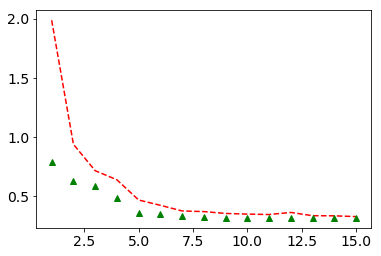

NameError: ignored

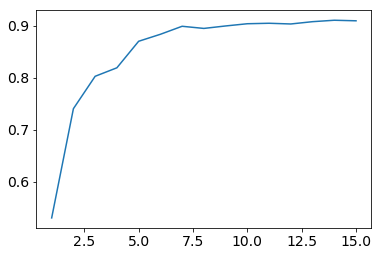

In [0]:
modelTrainer = ModelTrainer(cnnModelBuilder.model)
modelTrainer.trainModel()
modelTrainer.validate_model()

#imageClassifier = ImageClassifier(modelTrainer.model, modelTrainer.device, modelTrainer.loss_function) 
#imageClassifier.classify()

#imageClassifier = ImageClassifier(modelTrainer.model, modelTrainer.loss_function, modelTrainer.device) 
#imageClassifier.classify()